In [1]:
# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout
from keras.utils import print_summary
from keras import models
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import inception_v3
from keras_preprocessing.image import ImageDataGenerator
from scipy import pi


2.1.0


Using TensorFlow backend.


In [2]:
trainDF = pd.read_csv('/home/jupyter/Project/train.txt', sep=" ", header=None)
trainDF.columns = ['Images', 'SteeringAngle'] 
trainDF['SteeringAngle'] = trainDF['SteeringAngle'] * (pi / 180)

testDF = pd.read_csv('/home/jupyter/Project/test.txt', sep=" ", header=None)
testDF.columns = ['Images', 'SteeringAngle'] 

datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.25)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/home/jupyter/Project/train/",
x_col="Images",
y_col="SteeringAngle",
subset="training",
batch_size=100,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(200,75))

validation_generator = datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/home/jupyter/Project/train/",
x_col="Images",
y_col="SteeringAngle",
subset="validation",
batch_size=100,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(200,75))


Found 27342 validated image filenames.
Found 9113 validated image filenames.


In [3]:
from keras.regularizers import l2

def Inception_DataAug(width, height, depth):

    conv_base = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(height, width, depth))

    model = models.Sequential()
    model.add(conv_base)
    conv_base.trainable = False
    model.add(layers.Flatten())

    model.add(Dense(1164, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))    
    model.add(Dense(1, activation='linear'))

    return model


In [4]:
NUM_EPOCHS = 30

model = Inception_DataAug(width=75, height=200, depth=3)
print (model.summary())

model.compile(optimizer=Adam(lr=1e-4), loss="mse")

filepath = "/home/jupyter/Project/Inception/Inception_DA_Chkpt/Inception_DA_weights.{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

history = model.fit(
                train_generator,
                steps_per_epoch=329,
                epochs=NUM_EPOCHS,
                validation_data=validation_generator,
                validation_steps=37,
                callbacks=[checkpoint])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 4, 1, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1164)              9536652   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1164)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               116500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)               

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


avg_train_loss: 0.2047583151207823
avg_val_loss: 0.7484606053484185
difference: 0.5437022902276363


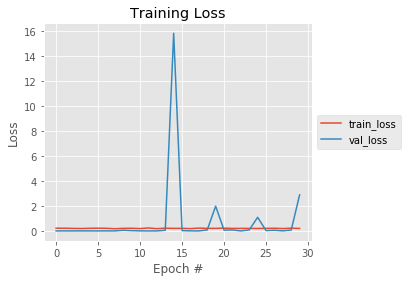

In [6]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

avg_train_loss = sum(history.history["loss"])/NUM_EPOCHS
avg_val_loss = sum(history.history["val_loss"])/NUM_EPOCHS

print("avg_train_loss: " + str(avg_train_loss))
print("avg_val_loss: " + str(avg_val_loss))
print("difference: " + str(abs(avg_train_loss - avg_val_loss)))

In [12]:
from keras.models import load_model

test_generator=test_datagen.flow_from_dataframe(
dataframe=testDF,
directory="/home/jupyter/Project/test/",
x_col="Images",
# y_col="SteeringAngle",
y_col=None,    
batch_size=100,
seed=42,
shuffle=False,
class_mode=None,
target_size=(200, 75))

filepath = "/home/jupyter/Project/Inception/Inception_DA_Chkpt/Inception_DA_weights.01-0.00.h5"

model.load_weights(filepath)


predictions = model.predict(test_generator)
print('Predictions: ', predictions.shape)

Found 8951 validated image filenames.
Predictions:  (8951, 1)


In [13]:
import pandas as pd

Images = testDF['Images']
preds = predictions
actual = testDF['SteeringAngle']

df_preds = pd.DataFrame(Images)
df_preds['Actual Steering Angle'] = (actual * (pi / 180))
df_preds['Predicted Steering Angle'] = preds
df_preds.rename(columns = {0:'Images'}, inplace = True) 

df_preds['MAE'] = 0

for i in range(len(df_preds)):
  df_preds.iloc[i, -1] = abs(df_preds.iloc[i, 1] - df_preds.iloc[i, 2])

mae_sum = 0
for i in range(len(df_preds)):
    mae_sum += df_preds.iloc[i, -1]
    
print("mae_sum: " + str(mae_sum))    
MAE = mae_sum / len(df_preds)
print("len(df_preds): " + str(len(df_preds)))
print("MAE: " + str(MAE))

mae_sum: 1930.5643540006038
len(df_preds): 8951
MAE: 0.21568141593124832


In [15]:
df_preds[8900:]

,Images,Actual Steering Angle,Predicted Steering Angle,MAE
8900,45355.jpg,0.103847,0.055946,0.047901
8901,45356.jpg,0.100356,0.062409,0.037947
8902,45357.jpg,0.093201,0.065619,0.027581
8903,45358.jpg,0.089710,0.053188,0.036522
8904,45359.jpg,0.086219,0.083216,0.003003
8905,45360.jpg,0.080983,0.080352,0.000632
8906,45361.jpg,0.074002,0.051661,0.022341
8907,45362.jpg,0.074002,0.073004,0.000998
8908,45363.jpg,0.066846,0.049831,0.017015
8909,45364.jpg,0.063355,0.070651,0.007296
